In [1]:
!pip install -q -U watermark

In [2]:
!pip install -qq transformers

In [3]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.11.0

numpy       : 1.24.2
pandas      : 1.5.3
torch       : 1.13.1
transformers: 4.26.1



In [4]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [9]:
## load the data

df= pd.read_csv("reviews.csv")
df.shape

(17456, 12)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17456 entries, 0 to 17455
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              17456 non-null  object
 1   userName              17456 non-null  object
 2   userImage             17456 non-null  object
 3   content               17456 non-null  object
 4   score                 17456 non-null  int64 
 5   thumbsUpCount         17456 non-null  int64 
 6   reviewCreatedVersion  14821 non-null  object
 7   at                    17456 non-null  object
 8   replyContent          9395 non-null   object
 9   repliedAt             9395 non-null   object
 10  sortOrder             17456 non-null  object
 11  appId                 17456 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.6+ MB


In [15]:
df.groupby(df.score).size()

score
1    3000
2    2814
3    5642
4    3000
5    3000
dtype: int64

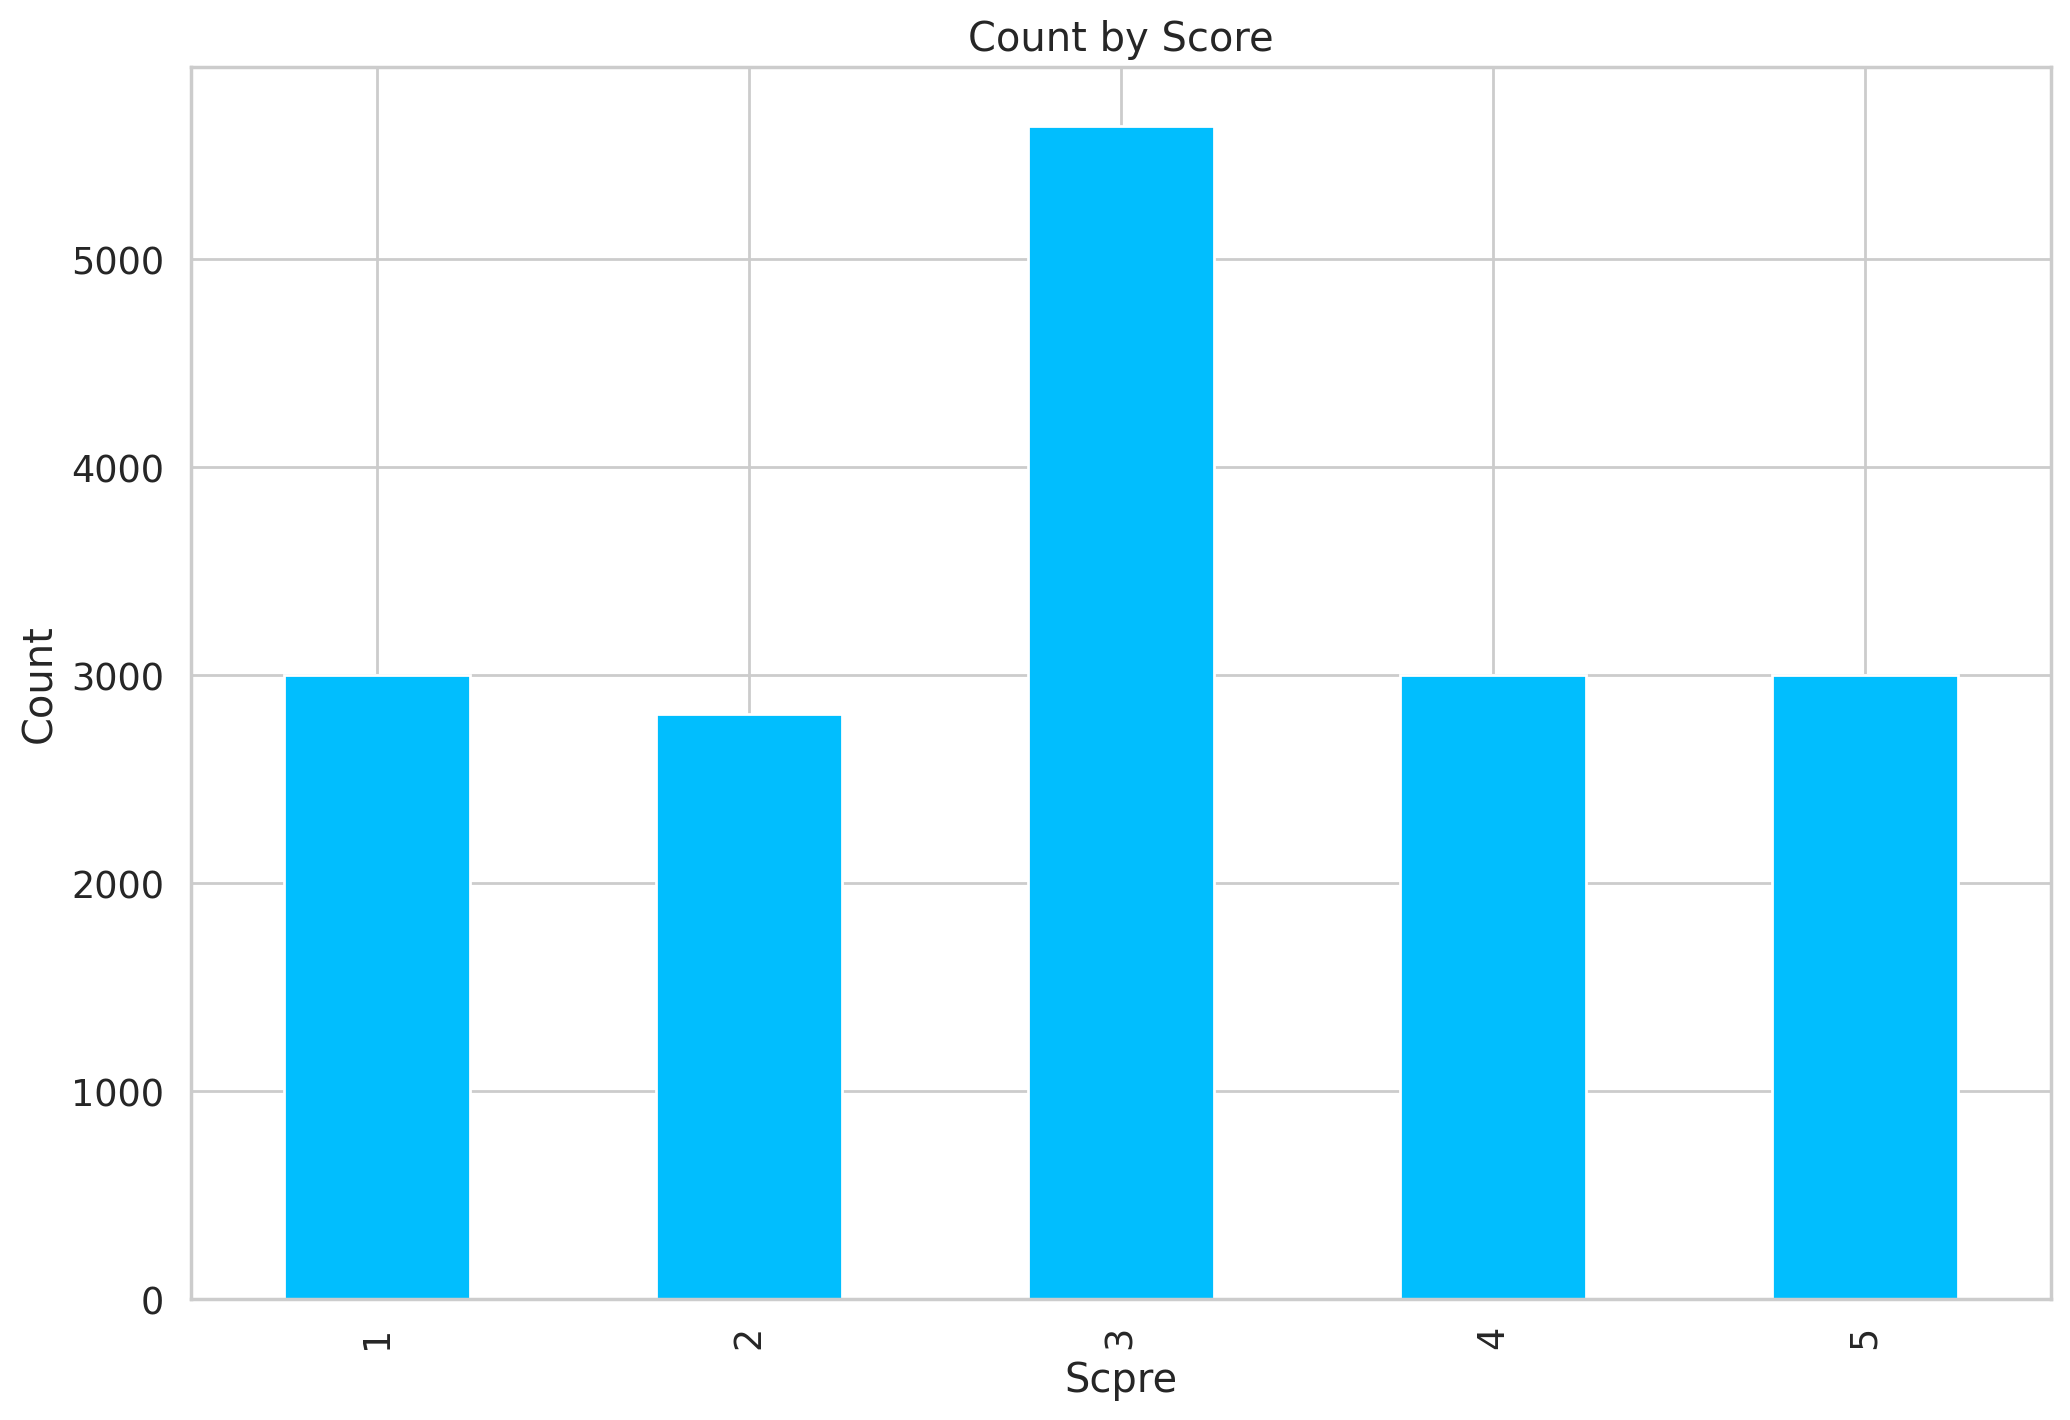

In [18]:
# no missing data which is good from the information part, what about class imbalance?

# get the value counts for each category
counts = df['score'].value_counts().sort_index()

# create a bar plot
counts.plot(kind='bar')

# set the title and axis labels
plt.title('Count by Score')
plt.xlabel('Scpre')
plt.ylabel('Count')

# show the plot
plt.show()


In [20]:
## apparently it is very much imbalanced, but i am going to convert the data to negative, neutral and positive sentiment
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

df['sentiment'] = df.score.apply(to_sentiment)



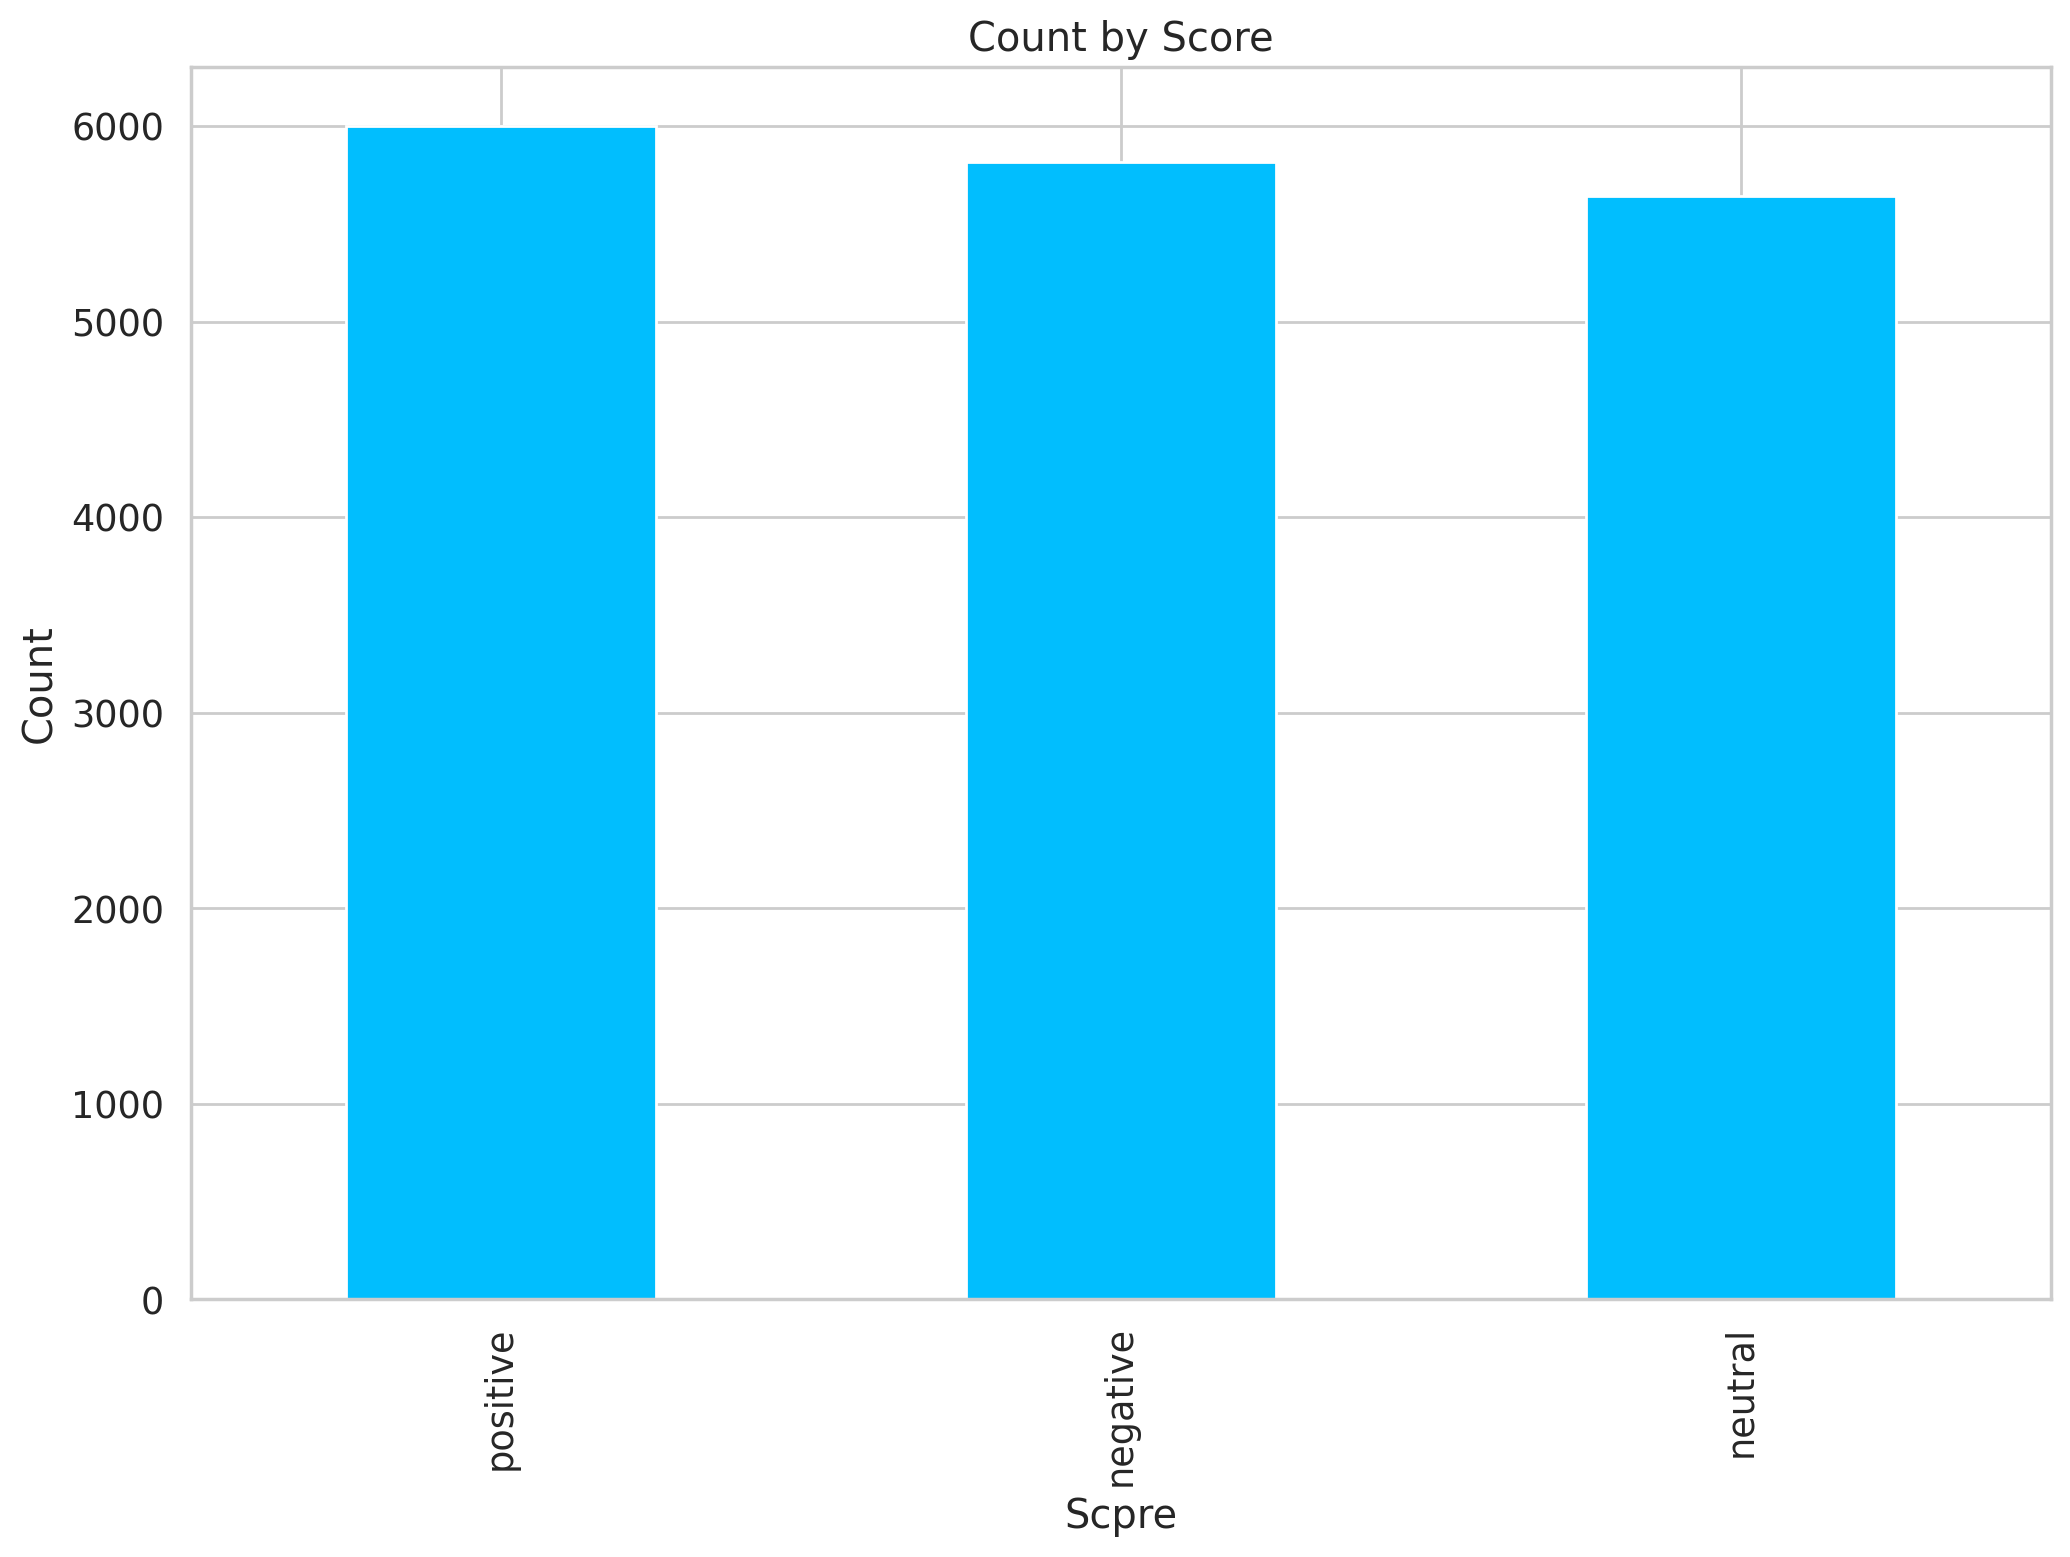

In [26]:
new_names = {0: 'negative', 1: 'neutral', 2: 'positive'}

# get the value counts for each category
counts = df['sentiment'].value_counts().rename(new_names)

# create a bar plot
counts.plot(kind='bar')

# set the title and axis labels
plt.title('Count by Score')
plt.xlabel('Scpre')
plt.ylabel('Count')

# show the plot
plt.show()

In [ ]:
### apprently it is getting more balanced


In [27]:
# specify the model 
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [28]:
### testing testing 
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

#### conver the text to tokens
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [29]:
# special tokens
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [30]:
# we must add this token to the start of each sentence, so that BERT knows i am doing classification
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [31]:
# special token for padding
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [32]:
#BERT understands tokens that were in the training set. 
# Everything else can be encoded using the [UNK] (unknown) token:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [33]:
### all these work can be done in encode_plus
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/codespace/.python/current/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

In [34]:
# the token now stored in a T   ensor and padded to a lenth of 32
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [35]:
# the attention mask has same length 
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [36]:
# we can inverse the tokenization to have a look at the special tokens
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [37]:
### chosing sequence length
#BERT works with fixed-length sequences. 
# We'll use a simple strategy to choose the max length. 
# Let's store the token length of each review:

token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

/tmp/ipykernel_16699/1971794795.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


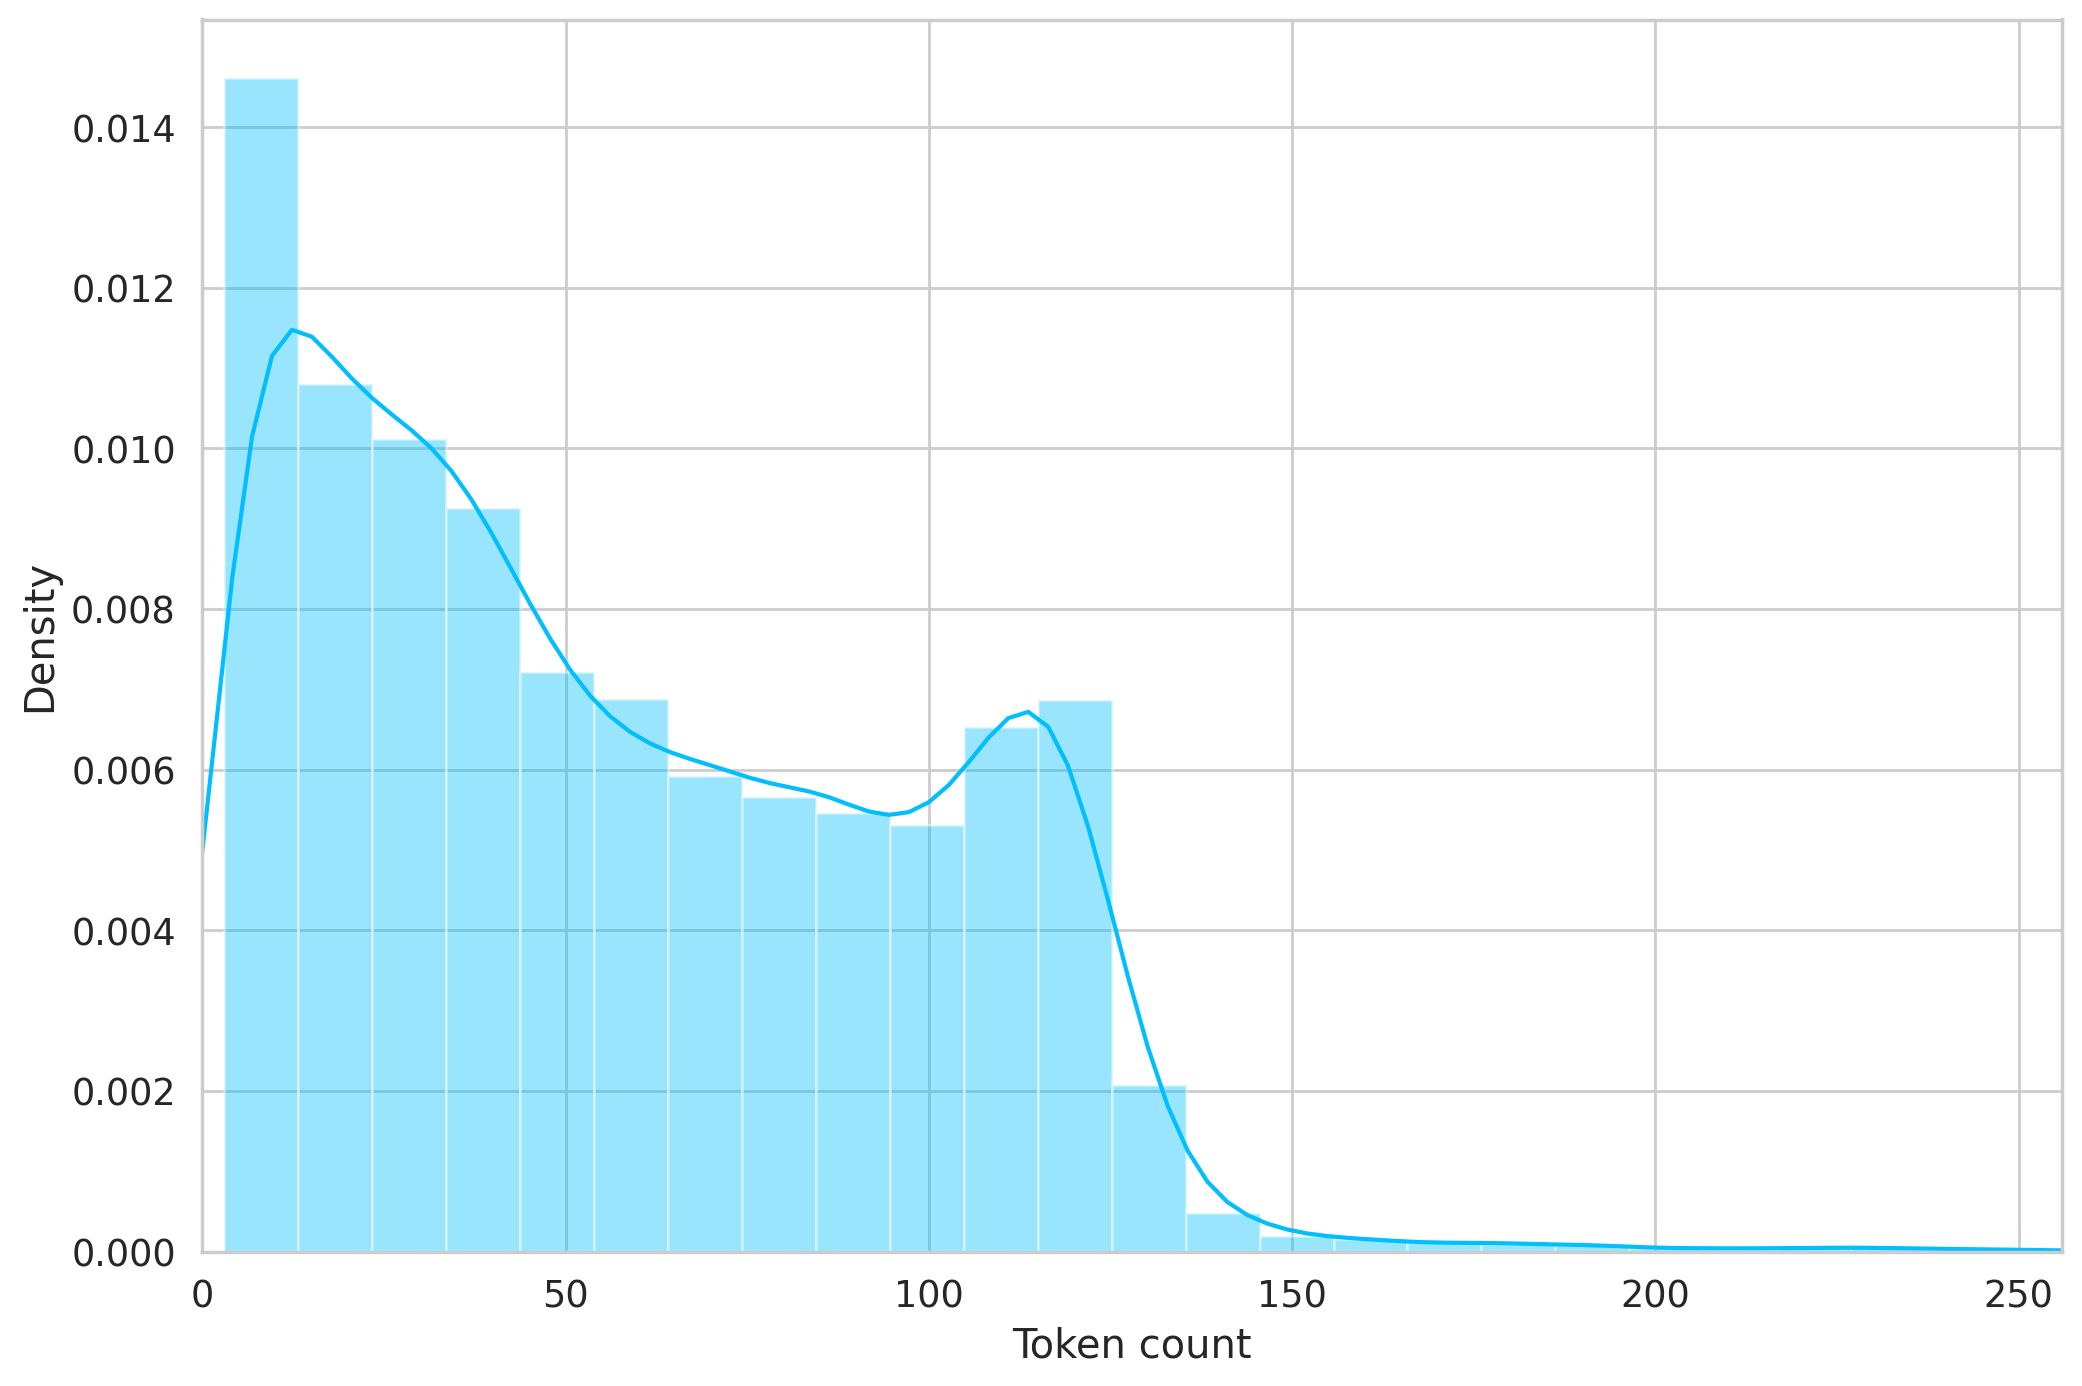

In [38]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [45]:
#Most of the reviews seem to contain less than 128 tokens, 
# but we'll be on the safe side and choose a maximum length of 160.
MAX_LEN=160

In [40]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [41]:
df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=RANDOM_SEED
)

df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [42]:
df_train.shape, df_val.shape, df_test.shape

((15710, 13), (873, 13), (873, 13))

In [43]:
# we need to create data loaders  -- the below is helper function

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [46]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/home/codespace/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [47]:
## look at the example batch from the training data loader

data = next(iter(train_data_loader))
data.keys()

/home/codespace/.python/current/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_l

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [48]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


tensor([[  101,  1103, 11984,  ...,     0,     0,     0],
        [  101,  3198,  3840,  ...,     0,     0,     0],
        [  101, 26660,  2591,  ...,     0,     0,     0],
        ...,
        [  101,   146,  1169,  ...,     0,     0,     0],
        [  101,  1302,  1104,  ...,     0,     0,     0],
        [  101,  1753,  2368,  ...,     0,     0,     0]])

In [51]:
### finally modelling
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


: 

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)